In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.transform import resize
from skimage.filters import gaussian

from vpt.features.features import *
import vpt.utils.image_processing as ip
import vpt.settings as s

%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

from keras import models

Using Theano backend.


In [3]:
from IPython.display import Audio
soundfile ='duetta1.wav'

In [4]:
participants = ["p1", "p3", "p4", "p5", "p6"]
base_folder = "data/posture"
hand_folder = "hand_data_M3_rad.3"

size = (120, 96)

In [5]:
# Load all data

X_lh = np.array([])
y_lh = np.array([])
X_rh = np.array([])
y_rh = np.array([])
filenames = np.array([])

for p in participants:
      
    folder = os.path.join(base_folder, p, hand_folder)
    X_lh = np.concatenate( (X_lh, np.load(os.path.join(folder, "X_lh.npy"))))
    y_lh = np.concatenate( (y_lh, np.load(os.path.join(folder, "y_lh.npy"))))
    X_rh = np.concatenate( (X_rh, np.load(os.path.join(folder, "X_rh.npy"))))
    y_rh = np.concatenate( (y_rh, np.load(os.path.join(folder, "y_rh.npy"))))
    filenames = np.concatenate( (filenames, np.load(os.path.join(folder, "filenames.npy"))))
    
print("LH:", X_lh.shape, y_lh.shape)
print("RH:", X_rh.shape, y_rh.shape)
print("Filenames:", filenames.shape)

LH: (17622,) (17622,)
RH: (17622,) (17622,)
Filenames: (17622,)


In [6]:
X_lh_ds = np.zeros((len(X_lh), size[0], size[1]))
X_rh_ds = np.zeros((len(X_rh), size[0], size[1]))

for i, (lh, rh) in enumerate(zip(X_lh, X_rh)):
    X_lh_ds[i] = resize(ip.normalize(lh), size, preserve_range=True)
    X_rh_ds[i] = resize(ip.normalize(rh), size, preserve_range=True)
    
X_lh_ds = X_lh_ds[:,:,:, np.newaxis]
X_rh_ds = X_rh_ds[:,:,:, np.newaxis]

/home/davidjo/vpt2/vpt2_py3/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [7]:
cae_lh = models.load_model("data/cae/lh_20171212_encoder_model.h5")
# cae_rh = models.load_model("data/cae/hands/rh_20171207_encoder_model.h5")

/home/davidjo/vpt2/vpt2_py3/lib/python3.5/site-packages/keras/models.py:251: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
encoded_imgs_lh = cae_lh.predict(X_lh_ds)
# encoded_imgs_rh = cae_lh.predict(X_rh_ds)

print("LH Shape", encoded_imgs_lh.shape)
# print("RH Shape", encoded_imgs_rh.shape)

LH Shape (17622, 300)


In [10]:
np.save("data/posture/all/encoded/encoded_imgs_lh_test.npy", encoded_imgs_lh)
# np.save("data/posture/all/encoded/encoded_imgs_rh.npy", encoded_imgs_rh)

In [ ]:
encoded_imgs_lh = np.load("data/posture/all/encoded/encoded_imgs_lh.npy")
# encoded_imgs_rh = np.load("data/posture/all/encoded/encoded_imgs_rh.npy")

In [9]:
Audio(url=soundfile, autoplay=True)

In [13]:
## find all "static" data so we can ignore for now
r = re.compile('p[\d]s')
# r2 = re.compile('p[\d]d')

# remove p#s data
vmatch = np.vectorize(lambda x:bool(r.search(x)))
rem_static = vmatch(filenames)

X_lh2, y_lh2, filenames2 = encoded_imgs_lh[~rem_static], y_lh[~rem_static], filenames[~rem_static]

# seperate p3 from data
r_p3 = re.compile('/p3/')
vmatch = np.vectorize(lambda x:bool(r_p3.search(x)))
sel = vmatch(filenames2)

#augment data with SMOTE (but first split it so we have some good testing data)
# X_train_lh, X_test_lh, y_train_lh, y_test_lh = train_test_split(X_lh2, y_lh2, test_size=.20)
X_train_lh, X_test_lh, y_train_lh, y_test_lh = X_lh2[~sel], X_lh2[sel], y_lh2[~sel], y_lh2[sel]
X_smote_lh, y_smote_lh = SMOTE(kind='svm').fit_sample(X_train_lh, y_train_lh)

SMOTE: (24226, 300) (24226,)
TEST: (2650, 300) (2650,)


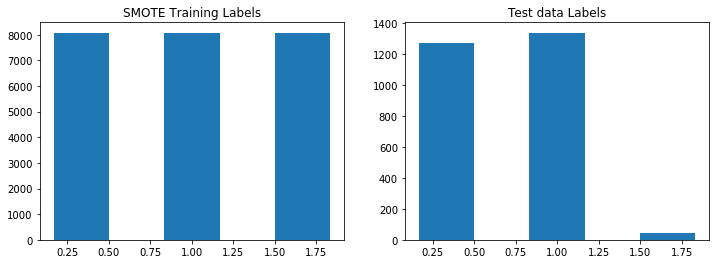

In [14]:
# Plot Data sets
print("SMOTE:", X_smote_lh.shape, y_smote_lh.shape)
print("TEST:", X_test_lh.shape, y_test_lh.shape)

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(y_smote_lh, bins=3, rwidth=.5)
plt.title("SMOTE Training Labels")

plt.subplot(122)
plt.hist(y_test_lh, bins=3, rwidth=.5)
plt.title("Test data Labels")

In [15]:
# Using Models selected in previous notebook (see model selection)
C = 100
gamma = .1
kernel = 'rbf'
clf_svm = SVC(C=C, gamma=gamma, kernel=kernel)

In [16]:
scores = cross_val_score(clf_svm, X_smote_lh, y_smote_lh)

In [17]:
print("Scores:", scores)
print("Avg Score:", np.average(scores))

Scores: [ 0.33333333  0.33333333  0.58694575]
Avg Score: 0.417870806154


In [18]:
clf_svm.fit(X_smote_lh, y_smote_lh)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [19]:
y_true, y_pred = y_test_lh, clf_svm.predict(X_test_lh)
print("Test Set Accuracy Score:", accuracy_score(y_true, y_pred))
print("Confustion Matrix:\n", confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

Test Set Accuracy Score: 0.478113207547
Confustion Matrix:
 [[1267    0    0]
 [1336    0    0]
 [  47    0    0]]
             precision    recall  f1-score   support

        0.0       0.48      1.00      0.65      1267
        1.0       0.00      0.00      0.00      1336
        2.0       0.00      0.00      0.00        47

avg / total       0.23      0.48      0.31      2650



/home/davidjo/vpt2/vpt2_py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
encoded_imgs_lh[1000]

array([ 0.00323127,  0.0035656 ,  0.0034933 ,  0.00343249,  0.00360331,
        0.00308309,  0.0033993 ,  0.00337801,  0.00351542,  0.00326293,
        0.00357859,  0.00348671,  0.0033434 ,  0.00350743,  0.00377488,
        0.0033717 ,  0.00348822,  0.00355613,  0.00312273,  0.00361942,
        0.00329591,  0.00374651,  0.00353696,  0.00304422,  0.00309629,
        0.00376256,  0.00357306,  0.00316045,  0.00349276,  0.00352161,
        0.00351974,  0.00326535,  0.00298072,  0.00326124,  0.003545  ,
        0.00322828,  0.00322062,  0.00346703,  0.00348149,  0.00348656,
        0.00322988,  0.0030623 ,  0.00318318,  0.00323526,  0.00364316,
        0.00339439,  0.00336812,  0.0032616 ,  0.00315093,  0.00324372,
        0.00328204,  0.00306144,  0.00359213,  0.00333313,  0.00345344,
        0.00309669,  0.00329078,  0.0032523 ,  0.00299221,  0.00321997,
        0.0031143 ,  0.0030593 ,  0.00389341,  0.00358836,  0.00322113,
        0.00307322,  0.00310824,  0.00321627,  0.0031581 ,  0.00